Sanity check on current weight maps. We'll try to recreate the results of Dai et al. (2015) first to make sure we're estimating the correct number of sources

In [1]:
# Import necessary packages
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline
#from scipy.integrate import quad
import matplotlib.pyplot as plt
from astropy.io import fits
import os

In [44]:
# Initalize python stuff

figsize = (10,6)
dpi = 170
fontsize = 10
# Configure parameters
plt.rcParams.update({'font.size': fontsize, 'figure.figsize': figsize, 'figure.dpi': dpi})

# Default tick label size
plt.rcParams['text.usetex'] = False
plt.rcParams['xtick.labelsize'] = fontsize
plt.rcParams['ytick.labelsize'] = fontsize
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 4
plt.rcParams['ytick.major.size'] = 4
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.width'] = 1

plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True
plt.rcParams['axes.linewidth'] = 1

In [7]:
# Read in AGN table:
path = '/Users/bbonine/ou/research/corr_func/data/'
cat = path + 'agntable_total.txt'
field = np.loadtxt(cat, dtype = str,delimiter = None, skiprows = 1, usecols=(15) , unpack = True)
x,y = np.loadtxt(cat, delimiter = None, skiprows = 1, usecols=(16,17) , unpack = True)

#Get rid of any duplicates:
field_list = np.unique(field)
len(field_list)

739

In [15]:
# Read in the flux limit file: 

lim = path + 'fluxlimit.txt'
exp, fluxlim = np.loadtxt(lim,skiprows = 1, unpack = True)
exp = np.power(10,exp) #exposure time in log units; convert

# Interpolate 
func1 = InterpolatedUnivariateSpline(exp,fluxlim) 


In [104]:
# Begin looping through fields

runs = 1
for i in range(410,411):
    pixel_angle_sec = (47.1262 / 20)**2 # [square arcseconds]
    pixel_angle_deg = (pixel_angle_sec / 3600**2)
    pix_scale = 47.1262 / 20 # arcseconds / pixel
    # Integrate the broken power law from the paper:
    a = 1.34
    b = 2.37 # +/- 0.01
    f_b = 3.67 * 10 ** (-15) # erg  cm^-2 s^-1
    k = 531.91*10**14 # +/- 250.04; (deg^-2 (erg cm^-2 s^-1)^-1)
    s_ref = 10**-14 # erg cm^-2 s^-1

    def f3(x):
        return (1/(-a+1))*(1/s_ref)**(-a)*k*(x**(-a+1))

    def f4(x):
        return (1/s_ref)**(-b)*k*(f_b/s_ref)**(b-a)*(1/(-b+1))*(x**(-b+1))
    
    # Read in the relevant exposure map:
    here = np.where(field == field_list[i])
    
    if os.path.isfile(path  + field[here][0] +'/expo.fits') == True:
        expmap = path + field[here][0] +'/expo.fits'
        print("Exposure map located")

        
        
    # Read in exposure map with astropy
        hdu_list = fits.open(expmap)
        image_data = hdu_list[0].data
        hdu_list.close()
        exp_map_1d =  image_data.ravel() #Conver exposure map to 1D array for later
        
      # Save reference pixel value for later
        ref_flux =  image_data[500,500]
    
        # Use the interpolated function to extract flux limit based off reference flux
        flux_lim = (func1(ref_flux))
    
        # Find the flux limit for each pixel:
        fluxlimit = np.zeros(len(exp_map_1d))
        for j in range(0,len(fluxlimit)):
            fluxlimit[j] = (func1(exp_map_1d[j]))
            
        fluxlimit_1d = np.asarray(fluxlimit) #convert to numpy array
        fluxlimit_2d = np.reshape(fluxlimit_1d,(-1,len(image_data[0])))


Exposure map located


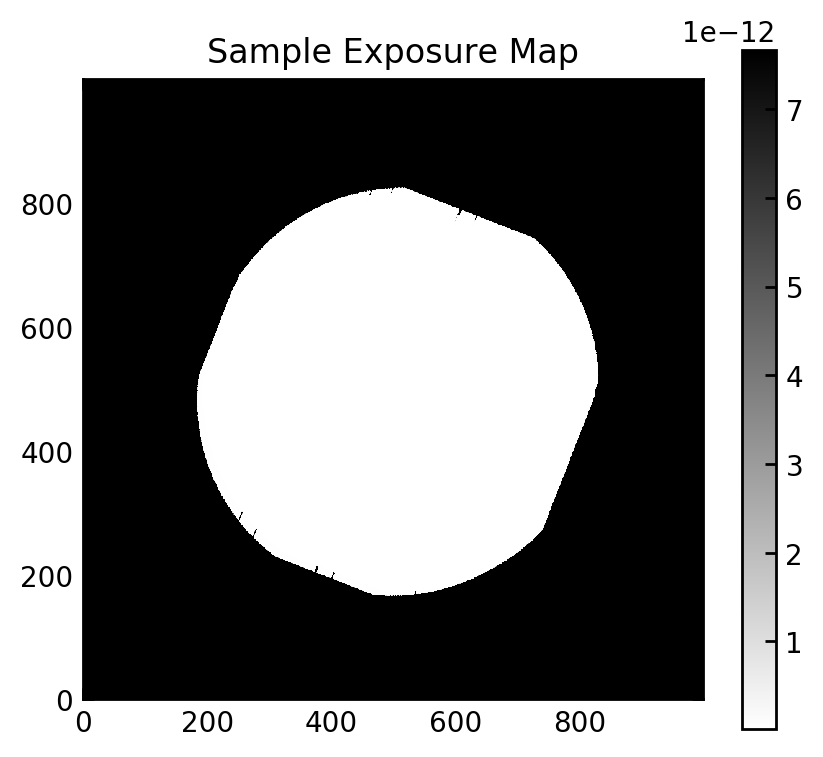

In [105]:
plt.figure(figsize = [5,5], dpi = 200)
plt.imshow(fluxlimit_2d, cmap = 'binary', origin = 'lower')
plt.title("Sample Exposure Map")
plt.colorbar(shrink = 0.9)

In [106]:
# Check to see if any pixels have flux limit lower than break flux
print(np.min(fluxlimit_1d))
print(f_b)

1.3016855436313016e-14
3.67e-15


Text(0, 0.5, 'N (>S)')

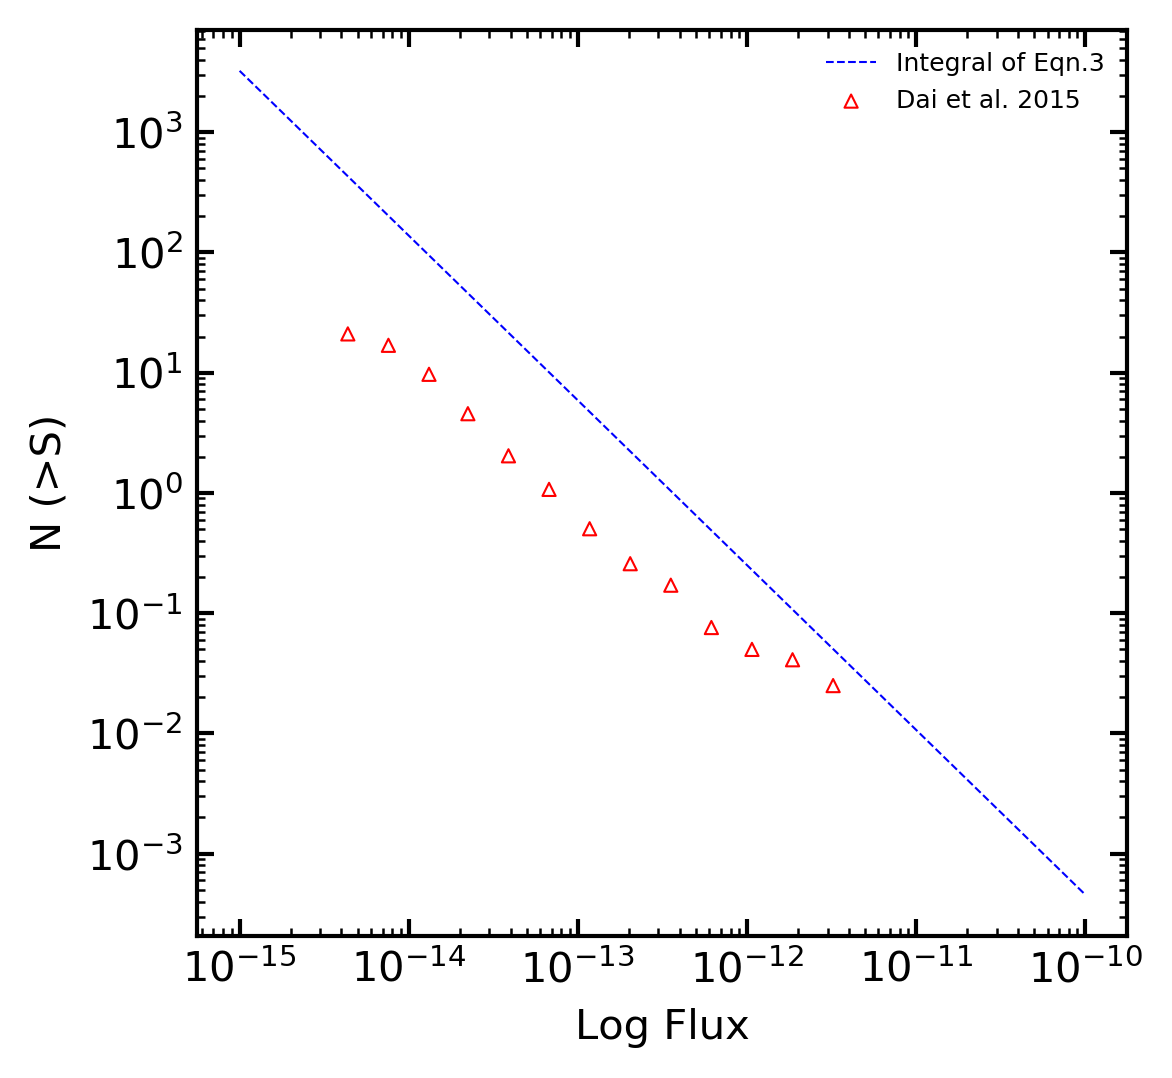

In [107]:
# Try replicating Fig. 18:
plt.figure(figsize = [4,4], dpi = 300)


# Data from paper:
n_vals = [21.030, 16.904, 9.701, 4.562, 2.037, 1.071, 0.504, 0.258, 0.171, 0.076, 0.050, 0.041, 0.025] 
log_s = [-14.36, -14.12, -13.88, -13.65, -13.41, -13.17, -12.93, -12.69, -12.45, -12.21, -11.97, -11.73, -11.49]

s_vals = np.power(10,log_s)
# Flux vector
flux_range = np.logspace(-15,-10,1000)
plt.loglog(flux_range,np.abs(f4(flux_range)), color = 'blue',label = 'Integral of Eqn.3', linestyle = '--', linewidth = 0.5)
plt.scatter(s_vals,n_vals, marker = '^', label = 'Dai et al. 2015', s = 10, facecolor = 'none', edgecolor = 'r', linewidth = .5)
plt.legend(fontsize = 6, frameon = False)
plt.xlabel('Log Flux')
plt.ylabel('N (>S)')


Text(0, 0.5, 'N (>S)')

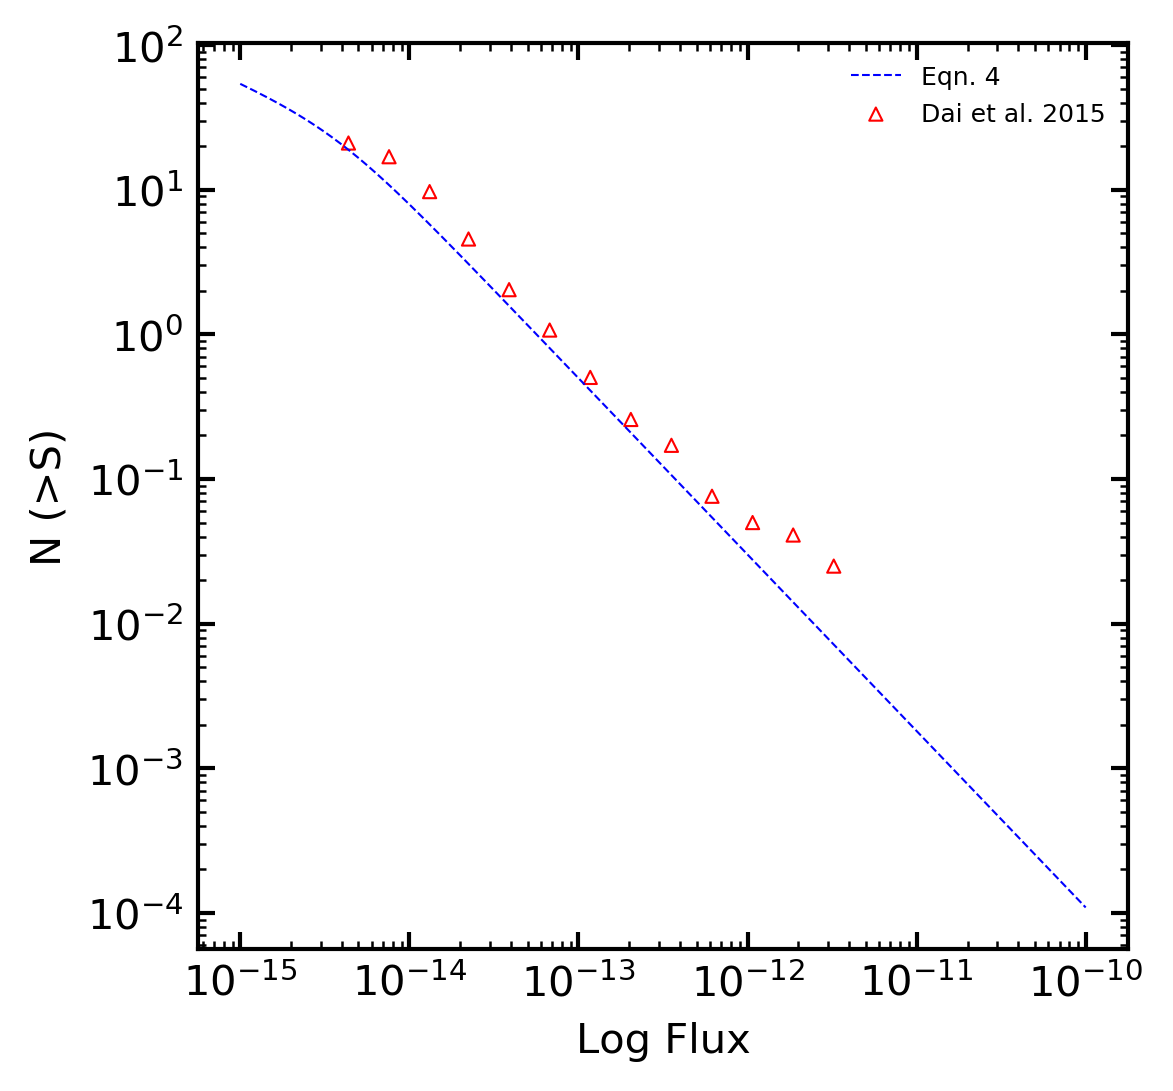

In [108]:
# Try again: Now using eqn 4.
c = 2
k_2 = 28.13
a_2 = 0.52
b_2= 1.22

def f5(x):
    return k_2*(x/f_b)**-a_2 / ((1+(x/f_b)**c)**((b_2-a_2)/c))

plt.figure(figsize = [4,4], dpi = 300)



plt.loglog(flux_range,np.abs(f5(flux_range)), color = 'blue',label = 'Eqn. 4', linestyle = '--', linewidth = 0.5)
plt.scatter(s_vals,n_vals, marker = '^', label = 'Dai et al. 2015', s = 10, facecolor = 'none', edgecolor = 'r', linewidth = .5)
plt.legend(fontsize = 6, frameon = False)
plt.xlabel('Log Flux')
plt.ylabel('N (>S)')

In [109]:
# Determine number of sources per pixel
Npix = np.zeros(len(fluxlimit_1d))
for j in range(0,len(fluxlimit_1d)):
    Npix[j] = np.abs(f4(fluxlimit_1d[j]))

print(Npix)


[0.01542755 0.01542755 0.01542755 ... 0.01542755 0.01542755 0.01542755]


So it looks like when we used our original function, we were over estimating the number of points.

In [110]:
'''
%%%%%%%%%%%%%%%%%%%%%%%%
 Construct weight map
%%%%%%%%%%%%%%%%%%%%%%%%
'''
pixel_angle_sec = (47.1262 / 20)**2 # [square arcseconds]

pixel_angle_deg = (pixel_angle_sec / 3600**2)# Convert to square degrees: 1 deg = 3600"

N_pixel = pixel_angle_deg*Npix # Sources per pixel

In [111]:
np.sum(N_pixel)

10.529683889492594

In [112]:
len(x[here])

19

In [123]:
# Try inspecting ratios again:


pixel_angle_sec = (47.1262 / 20)**2 # [square arcseconds]

pixel_angle_deg = (pixel_angle_sec / 3600**2)# Convert to square degrees: 1 deg = 3600"

runs = 10

ratios = np.zeros(runs)
for i in range(0,runs):
    pixel_angle_sec = (47.1262 / 20)**2 # [square arcseconds]
    pixel_angle_deg = (pixel_angle_sec / 3600**2)
    pix_scale = 47.1262 / 20 # arcseconds / pixel
    # Integrate the broken power law from the paper:
    a = 1.34
    b = 2.37 # +/- 0.01
    f_b = 3.67 * 10 ** (-15) # erg  cm^-2 s^-1
    k = 531.91*10**14 # +/- 250.04; (deg^-2 (erg cm^-2 s^-1)^-1)
    s_ref = 10**-14 # erg cm^-2 s^-1

    def f3(x):
        return (1/(-a+1))*(1/s_ref)**(-a)*k*(x**(-a+1))

    def f4(x):
        return (1/s_ref)**(-b)*k*(f_b/s_ref)**(b-a)*(1/(-b+1))*(x**(-b+1))
    
    # Read in the relevant exposure map:
    here = np.where(field == field_list[i])
    
    if os.path.isfile(path  + field[here][0] +'/expo.fits') == True:
        expmap = path + field[here][0] +'/expo.fits'
        print("Exposure map located")

        
        
    # Read in exposure map with astropy
        hdu_list = fits.open(expmap)
        image_data = hdu_list[0].data
        hdu_list.close()
        exp_map_1d =  image_data.ravel() #Conver exposure map to 1D array for later
        
      # Save reference pixel value for later
        ref_flux =  image_data[500,500]
    
        # Use the interpolated function to extract flux limit based off reference flux
        flux_lim = (func1(ref_flux))
    
        # Find the flux limit for each pixel:
        fluxlimit = np.zeros(len(exp_map_1d))
        for j in range(0,len(fluxlimit)):
            fluxlimit[j] = (func1(exp_map_1d[j]))
            
        fluxlimit_1d = np.asarray(fluxlimit) #convert to numpy array
        fluxlimit_2d = np.reshape(fluxlimit_1d,(-1,len(image_data[0])))
        
        # Determine number of sources per pixel
        Npix = np.zeros(len(fluxlimit_1d))
        for j in range(0,len(fluxlimit_1d)):
            Npix[j] = np.abs(f4(fluxlimit_1d[j]))

        N_pixel = pixel_angle_deg*Npix # Sources per pixel
        
        ratios[i] = (len(x[here])) / int(np.sum(N_pixel))

Exposure map located
Exposure map located
Exposure map located
Exposure map located
Exposure map located
Exposure map located
Exposure map located
Exposure map located


ZeroDivisionError: division by zero

In [121]:
N_pixel

array([6.60931908e-09, 6.60931908e-09, 6.60931908e-09, ...,
       6.60931908e-09, 6.60931908e-09, 6.60931908e-09])